## **Supervised Machine Learning: Regression - Project**
This notebook is part of my project required by IBM Supervised Machine Learning: Regression.

Data source: [Medical Cost Personal Datasets - Insurance Forecast by using Linear Regression](https://www.kaggle.com/mirichoi0218/insurance)

Notebook Contents: 
> 1. Dataset Description
> 2. Modifying Data
> 3. Linear Regression, LASSO and Ridge
> 4. Analyzing Results


### **1. Dataset Descriprtion**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNetCV 
from sklearn.pipeline import Pipeline

# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

# data = pd.read_csv('./car-data.csv', sep=',')
data = pd.read_csv('./insurance.csv', sep=',')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### **2. Modifying Data**

In [5]:
data = data.drop(['region'], axis = 1)
data.columns = [c.replace(' ', '_') for c in data.columns]
d = {'no': 0, 'yes': 1}
data['smoker'] = data['smoker'].map(d).fillna(data['smoker'])

d = {'male': 0, 'female': 1}
data['sex'] = data['sex'].map(d).fillna(data['sex'])

data.head()

,age,sex,bmi,children,smoker,charges
0,19,1,27.900,0,1,16884.92400
1,18,0,33.770,1,0,1725.55230
2,28,0,33.000,3,0,4449.46200
3,33,0,22.705,0,0,21984.47061
4,32,0,28.880,0,0,3866.85520


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

feature_cols = [x for x in train.columns if x != 'charges']
X_train = train[feature_cols]
y_train = train['charges']

X_test = test[feature_cols]
y_test = test['charges']

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 936 samples.
Testing set has 402 samples.


### **3. Linear regression, LASSO and Ridge Regression**

In [7]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)


#LINEAR REGRESSION

s = StandardScaler()
lr = LinearRegression()

X_train_s = s.fit_transform(X_train)
lr.fit(X_train_s, y_train)
X_test = s.transform(X_test)  
y_pred = lr.predict(X_test)
score = r2_score(y_test.values, y_pred)

# with pipeline
estimator = Pipeline([("scaler", s),("regression", lr)])
predictions_lr = cross_val_predict(estimator, X_train, y_train, cv=kf)
linear_score = r2_score(y_train, predictions_lr)

linear_score, score #almost identical

(0.7407061590011903, 0.7680881643600721)

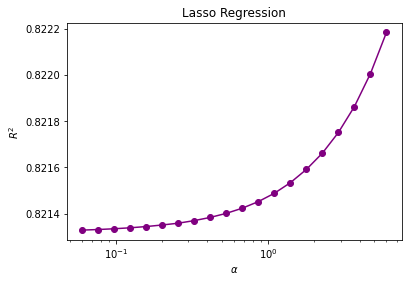

In [8]:
# LASSO
s = StandardScaler()
pf = PolynomialFeatures(degree=3)
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
predictions_lsr = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions_lsr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    
    score = r2_score(y_train, predictions_lsr)
    
    scores.append(score)
plt.semilogx(alphas, scores, '-o', color='purple')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [9]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X_train, y_train)
lasso_score = best_estimator.score(X_train, y_train)

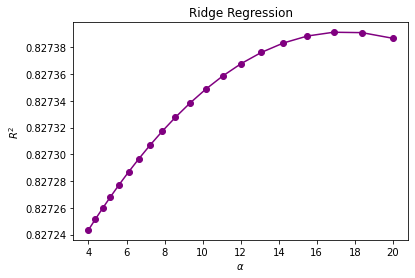

In [10]:
# ridge regression and K-fold cross validation
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
predictions_rr = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions_rr = cross_val_predict(estimator, X_train, y_train, cv = kf)
    score = r2_score(y_train, predictions_rr)
    scores.append(score)

plt.plot(alphas, scores, '-o', color='purple')
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [11]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("ridge_regression", Ridge(alpha=0.03))])

best_estimator.fit(X_train, y_train)
ridge_score = best_estimator.score(X_train, y_train)

In [12]:
# comparing scores
pd.DataFrame([[linear_score, lasso_score, ridge_score]],columns=['linear', 'lasso', 'ridge'], index=['score'])

,linear,lasso,ridge
score,0.740706,0.835473,0.835473


### **4. Analyzing Data**

In [13]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

# Fit a basic linear regression model
linearRegression = LinearRegression().fit(X_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Fit a regular (non-cross validated) Ridge model
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)
ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

# Fit a Lasso model using cross validation and determine the optimum value for 𝛼
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

# Fit elastic net with the same set of alphas as lasso
l1_ratios = np.linspace(0.1, 0.9, 9)
elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))


rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Lasso', 'Ridge' 'ElasticNet']

rmse_df = pd.DataFrame([[linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]],columns=['Linear', 'Lasso', 'Ridge', 'ElasticNet'], index=['rmse'])
rmse_df

,Linear,Lasso,Ridge,ElasticNet
rmse,30125.659647,30020.581241,30125.657535,30081.179584


[Text(0.5, 0, 'Actual'),
 Text(0, 0.5, 'Predicted'),
 Text(0.5, 1.0, 'Linear Regression Results')]

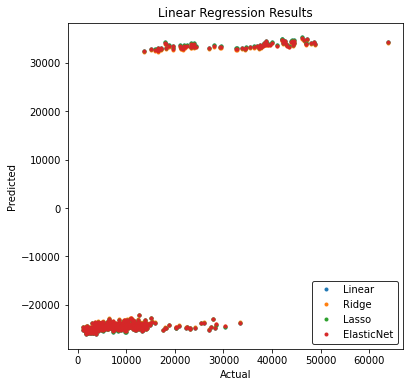

In [14]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels, models = ['Linear', 'Ridge', 'Lasso', 'ElasticNet'], [linearRegression, ridgeCV, lassoCV, elasticNetCV]

for mod, label in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), marker='o', ls='', ms=3.0, label=label, alpha=1)
    
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual', ylabel='Predicted', title='Linear Regression Results')